In [1]:
import numpy as np
import glob
import tensorflow as tf
from tensorflow.keras import Model, Input, regularizers, initializers
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D, Add, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pickle
from sklearn.utils import shuffle
import PIL.ImageOps
# import tensorflow_addons as tfa
from focal_loss import BinaryFocalLoss
# tf.debugging.set_log_device_placement(False)


In [2]:
lr_dense_images = glob.glob('/home/vr-lab/Asish/8th Sem Radar Project/LR-HR_Simulation/dense/HR/*.jpg') #returns path of images
lr_dense_images.sort()
print(len(lr_dense_images))
lr_sparse_images = glob.glob('/home/vr-lab/Asish/8th Sem Radar Project/LR-HR_Simulation/sparse/HR/*.jpg') #returns path of images
lr_sparse_images.sort()

3000


In [3]:
hr_dense_images = glob.glob('/home/vr-lab/Asish/8th Sem Radar Project/LR-HR_Simulation/dense/LR/*.jpg') #returns path of images
hr_dense_images.sort()
print(len(hr_dense_images))
hr_sparse_images = glob.glob('/home/vr-lab/Asish/8th Sem Radar Project/LR-HR_Simulation/sparse/LR/*.jpg') #returns path of images
hr_sparse_images.sort()

3000


In [4]:
from tqdm import tqdm
from multiprocessing import Pool
import random
progress = tqdm(total= len(lr_dense_images), position=0)
img_size=(256,256,1)
def read(path):
  img = image.load_img(path, color_mode='grayscale', target_size=img_size)
#   a = random.choice([0, 1])
#   if a == 0:
  img = PIL.ImageOps.invert(img)
  img = image.img_to_array(img)
  img = img/255.
  progress.update(1)
  return img

def read_wout_inv(path):
  img = image.load_img(path, color_mode='grayscale', target_size=img_size)
#   a = random.choice([0, 1])
#   if a == 0:
#   img = PIL.ImageOps.invert(img)
  img = image.img_to_array(img)
  img = img/255.
  progress.update(1)
  return img
  
p = Pool(10)

 41%|████      | 1235/3000 [00:22<00:15, 115.68it/s]

In [5]:
lr_train_img_array = p.map(read, lr_dense_images[:2200]) + p.map(read, lr_sparse_images[:2200])        # Put both sparse and dense in one variable
lr_val_img_array = p.map(read, lr_dense_images[2200:]) + p.map(read, lr_sparse_images[2200:])        # Put both sparse and dense in one variable

In [6]:
hr_train_img_array = p.map(read, hr_dense_images[:2200]) + p.map(read, hr_sparse_images[:2200])
hr_val_img_array = p.map(read, hr_dense_images[2200:]) + p.map(read, hr_sparse_images[2200:])

In [7]:
print(np.array(lr_train_img_array).shape)
print(np.array(lr_val_img_array).shape)
print(np.array(hr_train_img_array).shape)
print(np.array(hr_val_img_array).shape)

(4400, 256, 256, 1)
(1600, 256, 256, 1)
(4400, 256, 256, 1)
(1600, 256, 256, 1)


In [8]:
# Shuffle the arrays in unison for better training
lr_train, hr_train = shuffle(lr_train_img_array, hr_train_img_array, random_state=0)
lr_val, hr_val = shuffle(lr_val_img_array, hr_val_img_array, random_state=0)

In [9]:
lr_train = np.array(lr_train)
hr_train = np.array(hr_train)
lr_val = np.array(lr_val)
hr_val = np.array(hr_val)

# with tf.device('/GPU:0'):
#     lr_train = tf.convert_to_tensor(lr_train)
#     hr_train = tf.convert_to_tensor(hr_train)
#     lr_val = tf.convert_to_tensor(lr_val)
#     hr_val = tf.convert_to_tensor(hr_val)

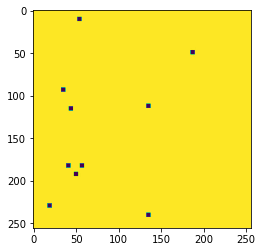

In [10]:
i=15
plt.imshow(hr_train[i])

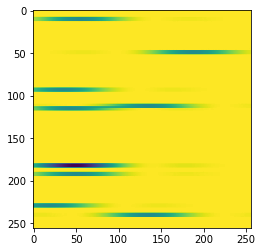

In [11]:
plt.imshow(lr_train[i])

In [12]:
import tensorflow.keras.backend as kb
def custom_loss(y_actual,y_pred):
    eps = 1e-20
    custom_loss = -0.99*y_actual*kb.log(kb.abs(y_pred) + eps) - 0.01*(1-y_actual)*kb.log(kb.abs(1-y_pred)+eps)
    return custom_loss

In [13]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.metrics import Accuracy, BinaryAccuracy
from sklearn.metrics import accuracy_score
import numpy as np
import tensorflow as tf

class F1_Score(tf.keras.metrics.Metric):

    def __init__(self, name='f1_score', **kwargs):
        super().__init__(name=name, **kwargs)
        self.f1 = self.add_weight(name='f1', initializer='zeros')
        self.precision_fn = Precision(thresholds=0.5)
        self.recall_fn = Recall(thresholds=0.5)

    def update_state(self, y_true, y_pred, sample_weight=None):
        p = self.precision_fn(y_true, y_pred)
        r = self.recall_fn(y_true, y_pred)
        # since f1 is a variable, we use assign
        self.f1.assign(2 * ((p * r) / (p + r + 1e-6)))

    def result(self):
        return self.f1

    def reset_states(self):
        # we also need to reset the state of the precision and recall objects
        self.precision_fn.reset_states()
        self.recall_fn.reset_states()
        self.f1.assign(0)

In [14]:
def f1_metric(y_true, y_pred):
    true_positives = kb.sum(kb.round(kb.clip(y_true * y_pred, 0, 1)))
    possible_positives = kb.sum(kb.round(kb.clip(y_true, 0, 1)))
    predicted_positives = kb.sum(kb.round(kb.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + kb.epsilon())
    recall = true_positives / (possible_positives + kb.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+kb.epsilon())
    return f1_val

In [15]:
# with tf.device('/GPU:0'):
Input_img = Input(shape=img_size)  

#encoding architecture
# x1 = Conv2D(64, (3, 3), activation='relu', padding='same', 
#             kernel_initializer=initializers.RandomNormal(stddev=5), bias_initializer='zeros')(Input_img)
x1 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer=initializers.RandomNormal(stddev=5), kernel_regularizer =tf.keras.regularizers.l1(l=0.01))(Input_img)
x2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer=initializers.RandomNormal(stddev=5), kernel_regularizer =tf.keras.regularizers.l1(l=0.01))(x1)
x3 = MaxPool2D(padding='same')(x2)
x4 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer=initializers.RandomNormal(stddev=5), kernel_regularizer =tf.keras.regularizers.l1(l=0.01))(x3)
x5 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer=initializers.RandomNormal(stddev=5), kernel_regularizer =tf.keras.regularizers.l1(l=0.01))(x4)
x6 = MaxPool2D(padding='same')(x5)
encoded = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer=initializers.RandomNormal(stddev=5), kernel_regularizer =tf.keras.regularizers.l1(l=0.01))(x6)
#encoded = Conv2D(64, (3, 3), activation='relu', padding='same')(x2)

# decoding architecture
x7 = UpSampling2D()(encoded)
x8 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer=initializers.RandomNormal(stddev=5), kernel_regularizer =tf.keras.regularizers.l1(l=0.01))(x7)
x9 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer=initializers.RandomNormal(stddev=5), kernel_regularizer =tf.keras.regularizers.l1(l=0.01))(x8)
x10 = Add()([x5, x9])
x11 = UpSampling2D()(x10)
x12 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer=initializers.RandomNormal(stddev=5), kernel_regularizer =tf.keras.regularizers.l1(l=0.01))(x11)
x13 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer=initializers.RandomNormal(stddev=5), kernel_regularizer =tf.keras.regularizers.l1(l=0.01))(x12)
x14 = Add()([x2, x13])
# x3 = UpSampling2D((2, 2))(x3)
# x2 = Conv2D(128, (3, 3), activation='relu', padding='same')(x3)
# x1 = Conv2D(256, (3, 3), activation='relu', padding='same')(x2)
decoded = Conv2D(1, (3, 3), padding='same',activation='softmax', kernel_initializer=initializers.RandomNormal(stddev=5), kernel_regularizer =tf.keras.regularizers.l1(l=0.01))(x14)
enc_dec = Model(Input_img, decoded)

# loss_rec = tf.reduce_mean(tf.image.ssim(truth, reconstructed, 2.0))
enc_dec.compile(optimizer='adam', loss=['mse'], metrics=['accuracy', f1_metric])

2022-05-13 20:42:49.976992: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-05-13 20:42:49.988768: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-13 20:42:50.045685: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [16]:
enc_dec.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 64) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [17]:
print("Num GPUs Available: ", tf.config.experimental.list_physical_devices('GPU'))

Num GPUs Available:  []


In [18]:
early_stopper = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=50, verbose=1, mode='min')
model_checkpoint =  ModelCheckpoint('models/SR_weightedce_checkpoint4.h5', save_best_only = True)

In [ ]:
history = enc_dec.fit(lr_train,hr_train, 
            batch_size=32,
            epochs=200,
            validation_data=(lr_val, hr_val),
            callbacks=[early_stopper, model_checkpoint])

Epoch 1/200


2022-05-13 19:57:38.976500: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1153433600 exceeds 10% of free system memory.
2022-05-13 19:57:39.781125: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1153433600 exceeds 10% of free system memory.
2022-05-13 19:57:42.330254: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 536870912 exceeds 10% of free system memory.
2022-05-13 19:57:42.429786: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 536870912 exceeds 10% of free system memory.
2022-05-13 19:57:43.321772: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 134217728 exceeds 10% of free system memory.


  2/138 [..............................] - ETA: 1:14:19 - loss: 44151.2227 - accuracy: 0.9959 - f1_metric: 0.9987

In [35]:
results = enc_dec.evaluate(lr_val, hr_val)
print('val_loss, val_accuracy', results)

50/50 [==============================] - 7s 146ms/step - loss: 17.4815 - accuracy: 0.0021 - f1_metric: 0.0053
val_loss, val_accuracy [17.481521606445312, 0.0021294783800840378, 0.005318781826645136]


In [ ]:
enc_dec.load_weights('models/SR_checkpoint4_with_and_wthout_inversion.h5')

In [ ]:
loss, acc = enc_dec.evaluate(lr_val, hr_val, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

In [36]:
pred = enc_dec.predict(lr_val)

In [37]:
print(pred.shape)

(1600, 256, 256, 1)


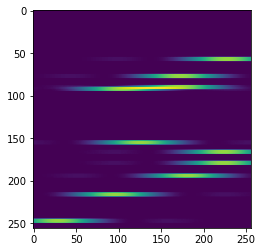

In [38]:
plt.imshow(lr_val[1])

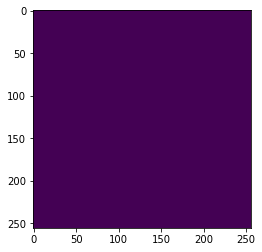

In [39]:
plt.imshow(pred[1])

In [33]:
print(custom_loss(lr_val[1], pred[1]))

tf.Tensor(
[[[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 ...

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]], shape=(256, 256, 1), dtype=float32)
